In [2]:
import numpy as np
import pickle
import os
import sys
import itertools as it
import string

import matplotlib.pyplot as plt
from mycolorpy import colorlist as mcp

import tqdm
import contextlib

import proplot as pplt

sys.path.append('../GDMaps_PCE/')
from DimensionReduction import Grassmann
from DimensionReduction import DiffusionMaps
from GDMaps_PCE_GSA_wLAR import *

from UQpy.distributions import Normal, Uniform, JointIndependent

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["mathtext.fontset"] = "stix" # "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15


USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [3]:
n_samples = 5120
n_runs = 10

# Micro

## Population: 100 agents

- Grassmannian dimensions $p = \{25, 70\}$
- Maximum polynomial degrees $s_{\max}  = \{z \mid 2 \leq z \leq 15, z \in \mathbb{Z}\}$

## Population: 320 agents

- Grassmannian dimensions $p = \{30, 100\}$
- Maximum polynomial degrees $s_{\max}  = \{z \mid 2 \leq z \leq 15, z \in \mathbb{Z}\}$

In [4]:
# population 100

with open('data/data_sugarscape/Sobol/output_array/SC_pop100_results_all_array.pickle', 'rb') as f:
    results_100_micro = pickle.load(f)
    
print(results_100_micro.shape)

n_agents_100 = results_100_micro.shape[2]
n_steps_100 = results_100_micro.shape[3]

(10, 5120, 100, 100)


In [5]:
# Count the number of elements where the last n values are identical
n=40

last_n_values = results_100_micro[:, :, :, -n:]

identical_mask = np.all(last_n_values == last_n_values[:, :, :, [0]], axis=-1)

count = np.sum(identical_mask)

print(count/(10*5120*100))
    

0.622314453125


In [6]:
# Ranks to plot as histogram
ranks_100_micro = []

num_runs = 10

for run in range(num_runs):
    data_all = results_100_micro[run]
    
    ranks_100_micro += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique_100_micro, counts_100_micro = np.unique(ranks_100_micro, return_counts=True)
print(f'Ranks: \n {np.asarray((unique_100_micro, counts_100_micro)).T}')

Ranks: 
 [[  63   10]
 [  65   20]
 [  66   40]
 [  67   70]
 [  68  120]
 [  69  180]
 [  70  340]
 [  71  600]
 [  72  610]
 [  73  980]
 [  74 1250]
 [  75 1860]
 [  76 2080]
 [  77 2790]
 [  78 2790]
 [  79 2930]
 [  80 2880]
 [  81 3260]
 [  82 3230]
 [  83 2820]
 [  84 3420]
 [  85 3370]
 [  86 3010]
 [  87 2880]
 [  88 2670]
 [  89 2200]
 [  90 1780]
 [  91 1120]
 [  92  930]
 [  93  640]
 [  94  150]
 [  95  130]
 [  96   30]
 [  97   10]]


In [7]:
# population 320

with open('data/data_sugarscape/Sobol/output_array/SC_pop320_results_all_array.pickle', 'rb') as f:
    results_320_micro = pickle.load(f)
    
n2 = results_320_micro.shape[2] * results_320_micro.shape[3]

reshaped_results_320_micro = results_320_micro.reshape(10, 5120, int(np.sqrt(n2)), int(np.sqrt(n2)))

print(reshaped_results_320_micro.shape)

n_agents_320 = reshaped_results_320_micro.shape[2]
n_steps_320 = reshaped_results_320_micro.shape[3]

(10, 5120, 160, 160)


In [8]:
# Count the number of elements where the last n values are identical
n=20

last_n_values = results_320_micro[:, :, :, -n:]

identical_mask = np.all(last_n_values == last_n_values[:, :, :, [0]], axis=-1)

count = np.sum(identical_mask)

print(count/(10*5120*320))

0.697540283203125


In [9]:
ranks_320_micro = []

num_runs = 10

for run in range(num_runs):
    data_all = reshaped_results_320_micro[run]
    
    ranks_320_micro += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique_320_micro, counts_320_micro = np.unique(ranks_320_micro, return_counts=True)
print(f'Ranks: \n {np.asarray((unique_320_micro, counts_320_micro)).T}')

Ranks: 
 [[  138    10]
 [  140    10]
 [  141    20]
 [  143    10]
 [  144    30]
 [  145    30]
 [  146    20]
 [  147    50]
 [  148    50]
 [  149    40]
 [  150   120]
 [  151    50]
 [  152   100]
 [  153   140]
 [  154   130]
 [  155   160]
 [  156   260]
 [  157   240]
 [  158   200]
 [  159   350]
 [  160 49180]]


# Macro (GLD)

## Overview of parameters:

- Population 100: $p=\{3,10\}$
- Population 320: $p=\{4,8\}$

In [22]:
with open('data/data_sugarscape/Sobol/output_array/SC_pop100_results_all_array.pickle', 'rb') as f:
    results_100 = pickle.load(f)

n_runs = results_100.shape[0]
n_param_combos = results_100.shape[1]
n_steps = results_100.shape[3]
n_lambdas = 4

if not os.path.exists('data/data_sugarscape/GLD/pop100_LMM.pickle'):
    lambdas_LMM = np.zeros((n_runs, n_param_combos, n_steps, n_lambdas))

    for run in range(n_runs):
        print('Run:', run)
        for param_id in tqdm.tqdm(range(n_param_combos)):
            for step in range(n_steps):
                data = results_100[run][param_id][:, step]
                with contextlib.redirect_stdout(None):
                    param_LMM = gld.fit_LMM(data,[0.5,0.5], disp_fit = False, maxiter=1000, maxfun=1000)

                    lambdas_LMM[run][param_id][step] = param_LMM
                    
    with open('data/data_sugarscape/GLD/pop100_LMM.pickle', 'wb') as f:
        pickle.dump(lambdas_LMM, f)    
else:
    with open('data/data_sugarscape/GLD/pop100_LMM.pickle', 'rb') as f:
        lambdas_LMM_100_result = pickle.load(f)

In [23]:
# We require a square matrix: 14x14=196 or 98+98 (remove two first tsteps from both lambdas tseries )
pop100_lambda34 = lambdas_LMM_100_result[:, :, 2:, 2:]

n_runs = 10
n_param_combos = 5120
n_responses = 2
n_steps = 98

pop100_lambda34_flat = np.zeros((n_runs, n_param_combos, n_responses*n_steps))

for run in range(n_runs):
    for param_id in range(n_param_combos):
        pop100_lambda34_flat[run, param_id, :] = pop100_lambda34[run][param_id].T.ravel()
        
n2 = n_responses*n_steps

pop100_lambda34_reshaped = pop100_lambda34_flat.reshape(10, 5120, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [24]:
ranks_100_GLD = []

num_runs = 10

for run in range(num_runs):
    data_all = pop100_lambda34_reshaped[run]
    
    ranks_100_GLD += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique_100_GLD, counts_100_GLD = np.unique(ranks_100_GLD, return_counts=True)
print(f'Ranks: \n {np.asarray((unique_100_GLD, counts_100_GLD )).T}')

Ranks: 
 [[   14 51200]]


In [25]:
with open('data/data_sugarscape/Sobol/output_array/SC_pop320_results_all_array.pickle', 'rb') as f:
    results = pickle.load(f)

n_runs = results.shape[0]
n_param_combos = results.shape[1]
n_steps = results.shape[3]
n_lambdas = 4


if not os.path.exists('data/data_sugarscape/GLD/pop320_LMM2.pickle'):
    lambdas_LMM = np.zeros((n_runs, n_param_combos, n_steps, n_lambdas))

    for run in range(n_runs):
        print('Run:', run)
        for param_id in tqdm.tqdm(range(n_param_combos)):
            for step in range(n_steps):
                data = results[run][param_id][:, step]
                with contextlib.redirect_stdout(None):
                    param_LMM = gld.fit_LMM(data,[0.5,0.5], disp_fit = False, maxiter=1000, maxfun=1000)

                    lambdas_LMM[run][param_id][step] = param_LMM
                    
    with open('data/data_sugarscape/GLD/pop320_LMM2.pickle', 'wb') as f:
        pickle.dump(lambdas_LMM, f)    
else:
    with open('data/data_sugarscape/GLD/pop320_LMM2.pickle', 'rb') as f:
        lambdas_LMM_320_result = pickle.load(f)
    

In [26]:
# We require a square matrix: 12x12=144 or 72+72 (remove 8 first tsteps, and consider only last two lambdas)
pop320_lambda34 = lambdas_LMM_320_result[:, :, 8:, 2:]

pop320_lambda34_flat = np.zeros((n_runs, n_param_combos, 2*72))

for run in range(n_runs):
    for param_id in range(n_param_combos):
        pop320_lambda34_flat[run, param_id, :] = pop320_lambda34[run][param_id].T.ravel()
        
n2 = 2*72

pop320_lambda34_reshaped = pop320_lambda34_flat.reshape(10, 5120, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [27]:
ranks_320_GLD = []

num_runs = 10

for run in range(num_runs):
    data_all = pop320_lambda34_reshaped[run]
    
    ranks_320_GLD += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique_320_GLD, counts_320_GLD = np.unique(ranks_320_GLD, return_counts=True)
print(f'Ranks: \n {np.asarray((unique_320_GLD, counts_320_GLD)).T}')

Ranks: 
 [[   12 51200]]


# Macro (average trajectory)

In [28]:
with open('data/data_sugarscape/Sobol/output_array/SC_pop100_results_all_array.pickle', 'rb') as f:
    results = pickle.load(f)

n_runs = results.shape[0]
n_param_combos = results.shape[1]
n_steps = results.shape[3]

if not os.path.exists('data/data_sugarscape/mean_macro/pop100_mean.pickle'):
    pop100_mean = np.zeros((n_runs, n_param_combos, n_steps, 1))

    for run in range(n_runs):
        print('Run:', run)
        for param_id in tqdm.tqdm(range(n_param_combos)):
            for step in range(n_steps):
                pop100_mean[run][param_id][step] = np.mean(results[run][param_id][:, step])
                    
    with open('data/data_sugarscape/mean_macro/pop100_mean.pickle', 'wb') as f:
        pickle.dump(pop100_mean, f)    
else:
    with open('data/data_sugarscape/mean_macro/pop100_mean.pickle', 'rb') as f:
        pop100_mean_result = pickle.load(f)

In [29]:
n2 = n_steps

pop100_mean_reshaped = pop100_mean_result.reshape(10, 5120, int(np.sqrt(n2)), int(np.sqrt(n2)))

In [30]:
ranks_100_mean = []

num_runs = 10

for run in range(num_runs):
    data_all = pop100_mean_reshaped[run]
    
    ranks_100_mean += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique_100_mean, counts_100_mean = np.unique(ranks_100_mean, return_counts=True)
print(f'Ranks: \n {np.asarray((unique_100_mean, counts_100_mean)).T}')

Ranks: 
 [[   10 51200]]


In [31]:
with open('data/data_sugarscape/Sobol/output_array/SC_pop320_results_all_array.pickle', 'rb') as f:
    results = pickle.load(f)
    
n_runs = results.shape[0]
n_param_combos = results.shape[1]
n_steps = results.shape[3]

if not os.path.exists('data/data_sugarscape/mean_macro/pop320_mean.pickle'):
    pop320_mean = np.zeros((n_runs, n_param_combos, n_steps, 1))

    for run in range(n_runs):
        print('Run:', run)
        for param_id in tqdm.tqdm(range(n_param_combos)):
            for step in range(n_steps):
                pop320_mean[run][param_id][step] = np.mean(results[run][param_id][:, step])
                    
    with open('data/data_sugarscape/mean_macro/pop320_mean.pickle', 'wb') as f:
        pickle.dump(pop320_mean, f)    
else:
    with open('data/data_sugarscape/mean_macro/pop320_mean.pickle', 'rb') as f:
        pop320_mean_result = pickle.load(f)

In [32]:
# remove 8 first tsteps,

n2 = n_steps-16

pop320_mean = pop320_mean_result[:, :, 16:]

pop320_mean_reshaped = pop320_mean.reshape(10, 5120, int(np.sqrt(n2)), int(np.sqrt(n2)))


In [33]:
ranks_320_mean = []

num_runs = 10

for run in range(num_runs):
    data_all = pop320_mean_reshaped[run]
    
    ranks_320_mean += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique_320_mean, counts_320_mean = np.unique(ranks_320_mean, return_counts=True)
print(f'Ranks: \n {np.asarray((unique_320_mean, counts_320_mean)).T}')

Ranks: 
 [[    8 51200]]


## Trajectories

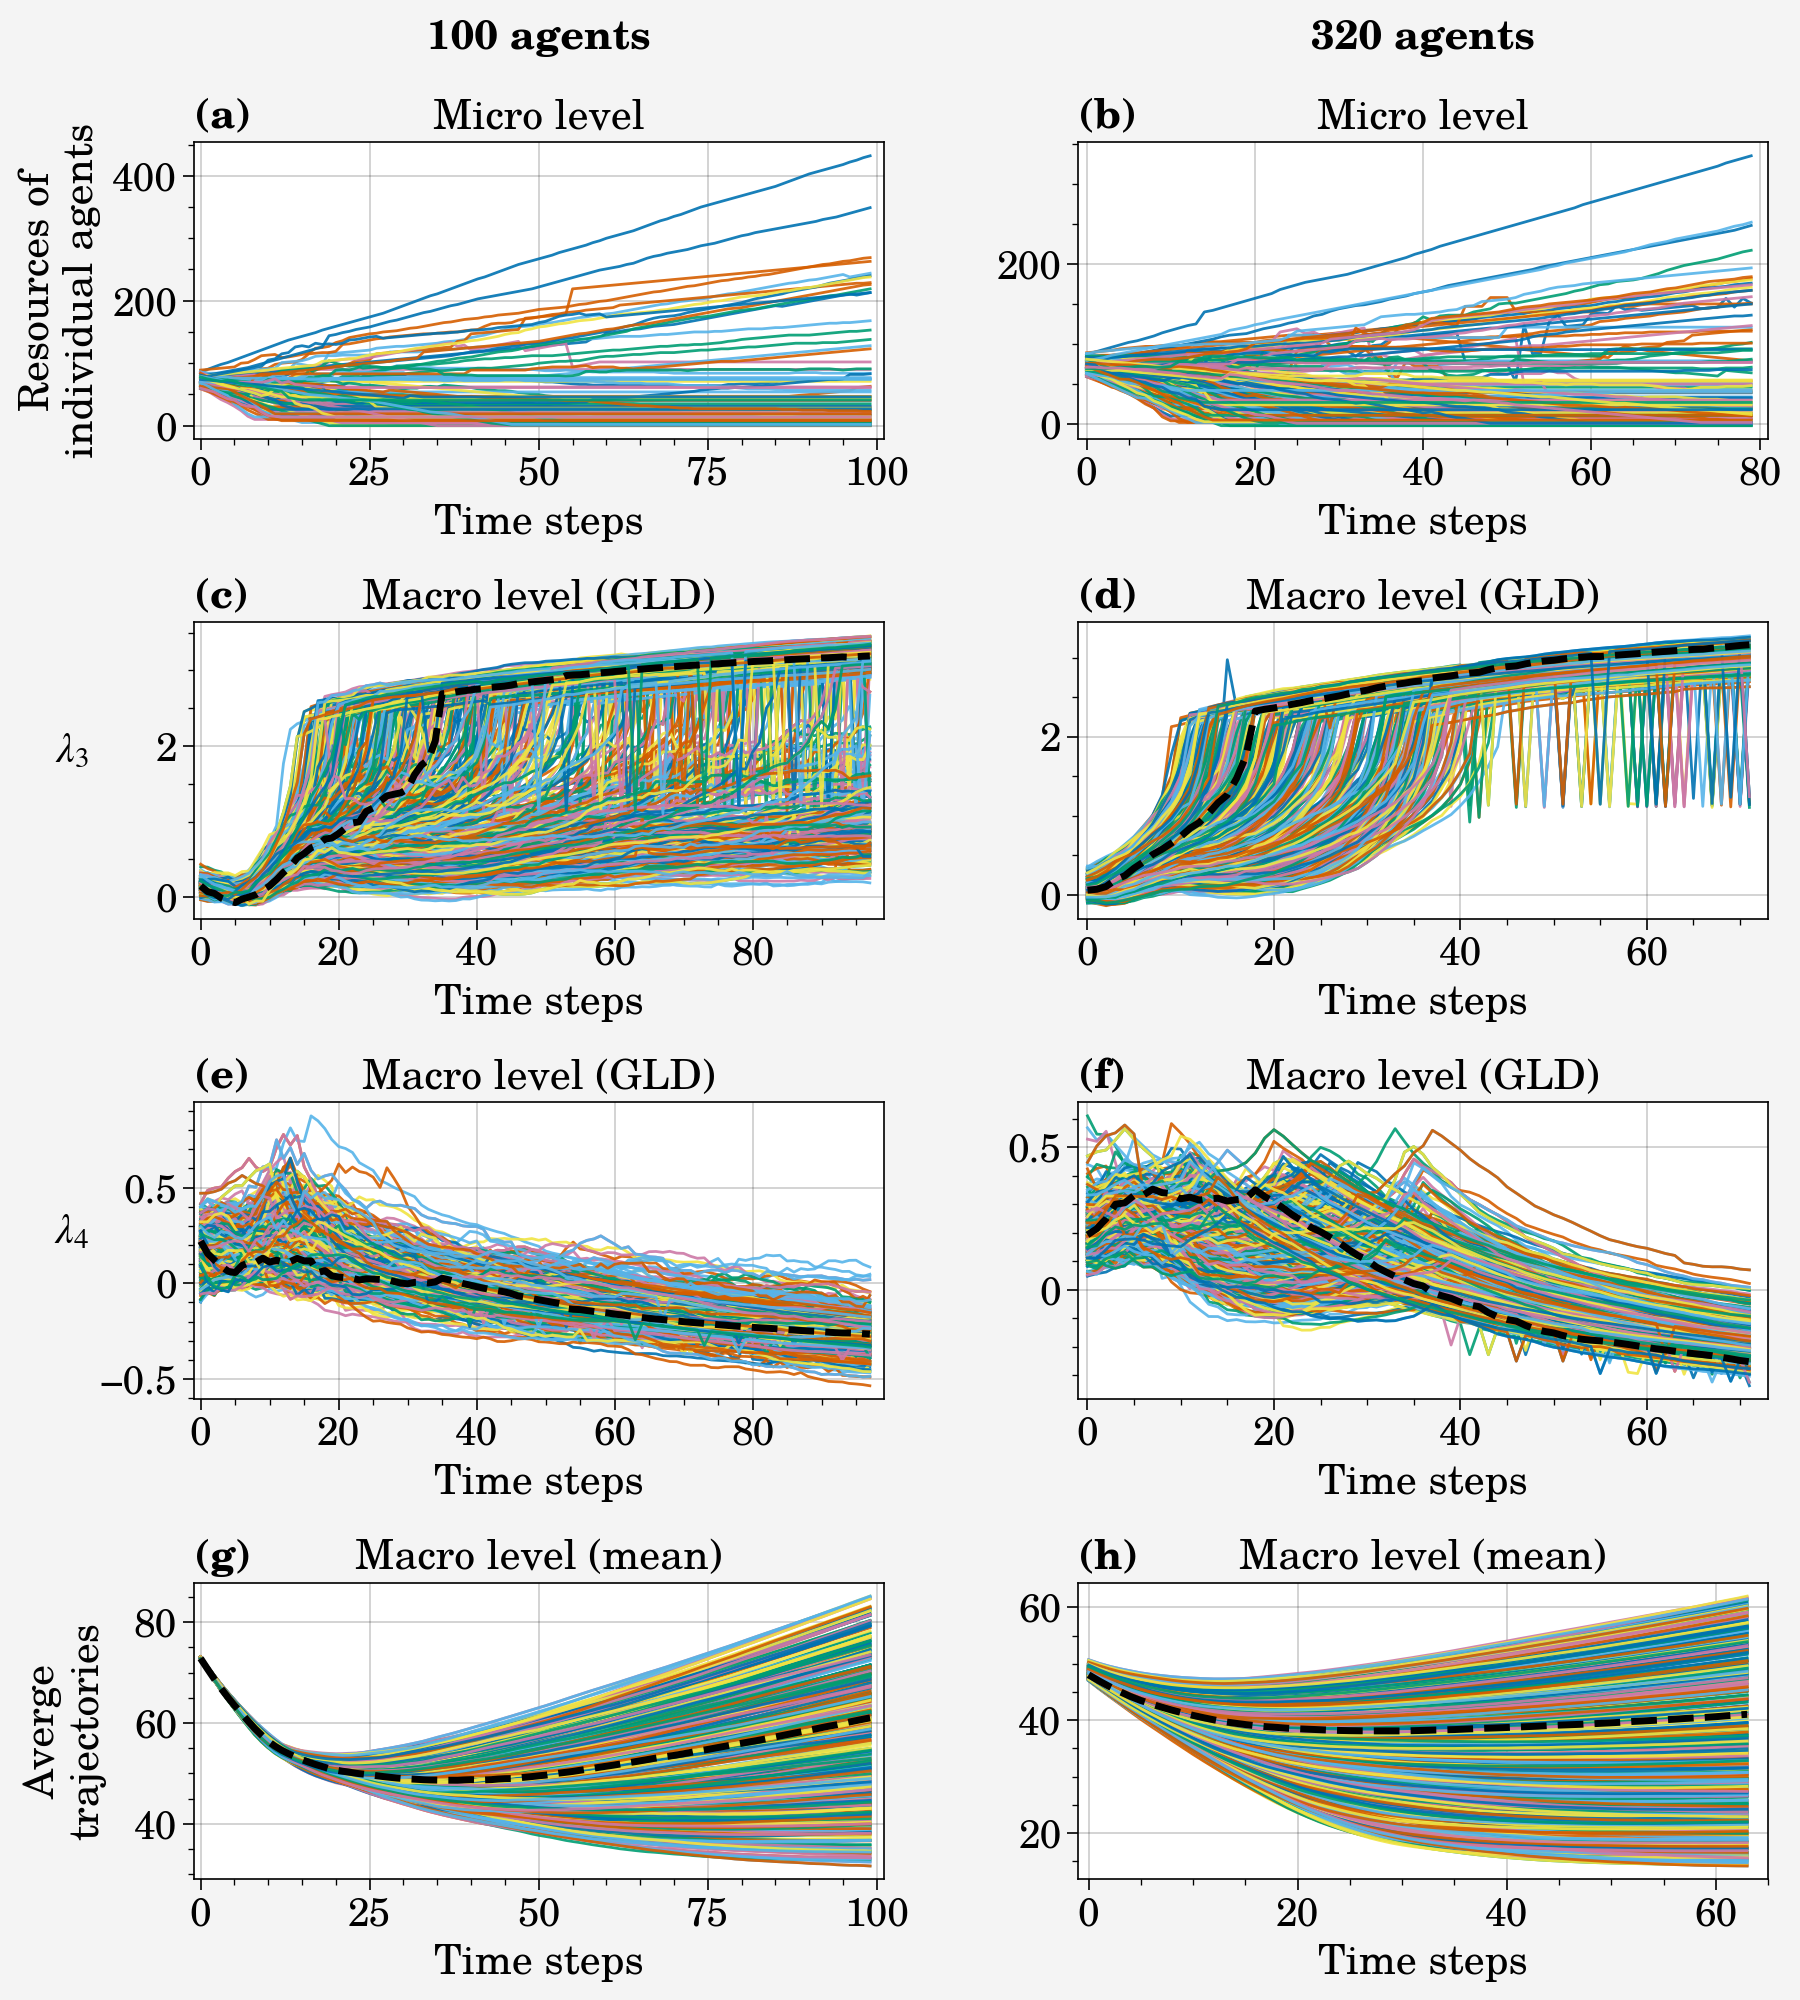

In [47]:
pplt.rc['tick.labelsize'] = 13

fig, axs = pplt.subplots(ncols=2, nrows=4, figsize=(9, 10), sharey=False, sharex=False)

colors=mcp.gen_color(cmap="Dark2",n=7)

# Micro trajectories
for i in range(n_agents_100):
    axs[0].plot(results_100_micro[0][600][i], alpha=0.9, lw=1)
    axs[0].set_xlim(-1, 101)

for i in range(n_agents_320):
    axs[1].plot(results_320_micro[0][600][i], alpha=0.9, lw=1)
    axs[1].set_xlim(-1, 81)

for ax in [axs[0],axs[1]]:
    ax.set_xlabel("Time steps")
    ax.set_title("Micro level")

axs[0].set_ylabel("Resources of\nindividual agents")
axs[1].set_ylabel(" ")


# GLD trajectories

for i in np.concatenate((np.arange(0, 600, 1), 
                np.arange(601, 128*5, 1, dtype="int")), axis=None):

    axs[2].plot(pop100_lambda34[0][i][:,0], alpha=0.9, lw=1)
    axs[2].set_xlim(-1, 99)

    axs[3].plot(pop320_lambda34[0][i][:,0], alpha=0.9, lw=1)
    axs[3].set_xlim(-1, 73)
    
    axs[4].plot(pop100_lambda34[0][i][:,1], alpha=0.9, lw=1)
    axs[4].set_xlim(-1, 99)

    axs[5].plot(pop320_lambda34[0][i][:,1], alpha=0.9, lw=1)
    axs[5].set_xlim(-1, 73)
    
axs[2].plot(pop100_lambda34[0][600][:,0], color='black', linestyle='--',  lw=2.5)
axs[3].plot(pop320_lambda34[0][600][:,0], color='black', linestyle='--',  lw=2.5)
axs[4].plot(pop100_lambda34[0][600][:,1], color='black', linestyle='--',  lw=2.5)
axs[5].plot(pop320_lambda34[0][600][:,1], color='black', linestyle='--',  lw=2.5)

axs[2].set_ylabel(r"$\lambda_3$", fontsize=18, labelpad=30)
axs[4].set_ylabel(r"$\lambda_4$", fontsize=18, labelpad=10)

for ax in [axs[3], axs[5]]:
    ax.set_ylabel(" ")
    
for ax in [axs[2], axs[3], axs[4], axs[5]]:
    ax.set_xlabel("Time steps")
    ax.set_title("Macro level (GLD)")
    ax.yaxis.label.set(rotation='horizontal', ha='left')


# Average trajectories
for i in np.concatenate((np.arange(0, 600, 1), 
                np.arange(601, 128*5, 1, dtype="int")), axis=None):
    axs[6].plot(pop100_mean_result[0][i][:], alpha=0.9, lw=1)
    axs[6].set_xlim(-1, 101)

    axs[7].plot(pop320_mean[0][i][:], alpha=0.9, lw=1)
    axs[7].set_xlim(-1, 65)
    
axs[6].plot(pop100_mean_result[0][600][:], color='black', linestyle='--',  lw=2.5)
axs[7].plot(pop320_mean[0][600][:], color='black', linestyle='--',  lw=2.5)

for ax in [axs[6], axs[7]]:
    ax.set_xlabel("Time steps")
    ax.set_title("Macro level (mean)")
    

axs[6].set_ylabel("Averge\ntrajectories", fontsize=18, labelpad=10)
axs[7].set_ylabel(" ")


axs.format(toplabels=["100 agents", "320 agents"])
axs.format(abc='(a)')

axs.format(rc_kw={'label.size': 15,
                  'suptitle.size': 15,
                  'tick.labelsize': 14,
                  'title.size': 15,
                  'toplabel.pad': 15,
                  'toplabel.color': "k"})

plt.tight_layout()
plt.savefig('plots/Sugarscape/Sugarscape_all_traj.pdf', dpi=150, bbox_inches='tight')
plt.show()

## Scree-plots

In [24]:
PATH_TO_RESULTS = "data/data_sugarscape/GSA_results/"

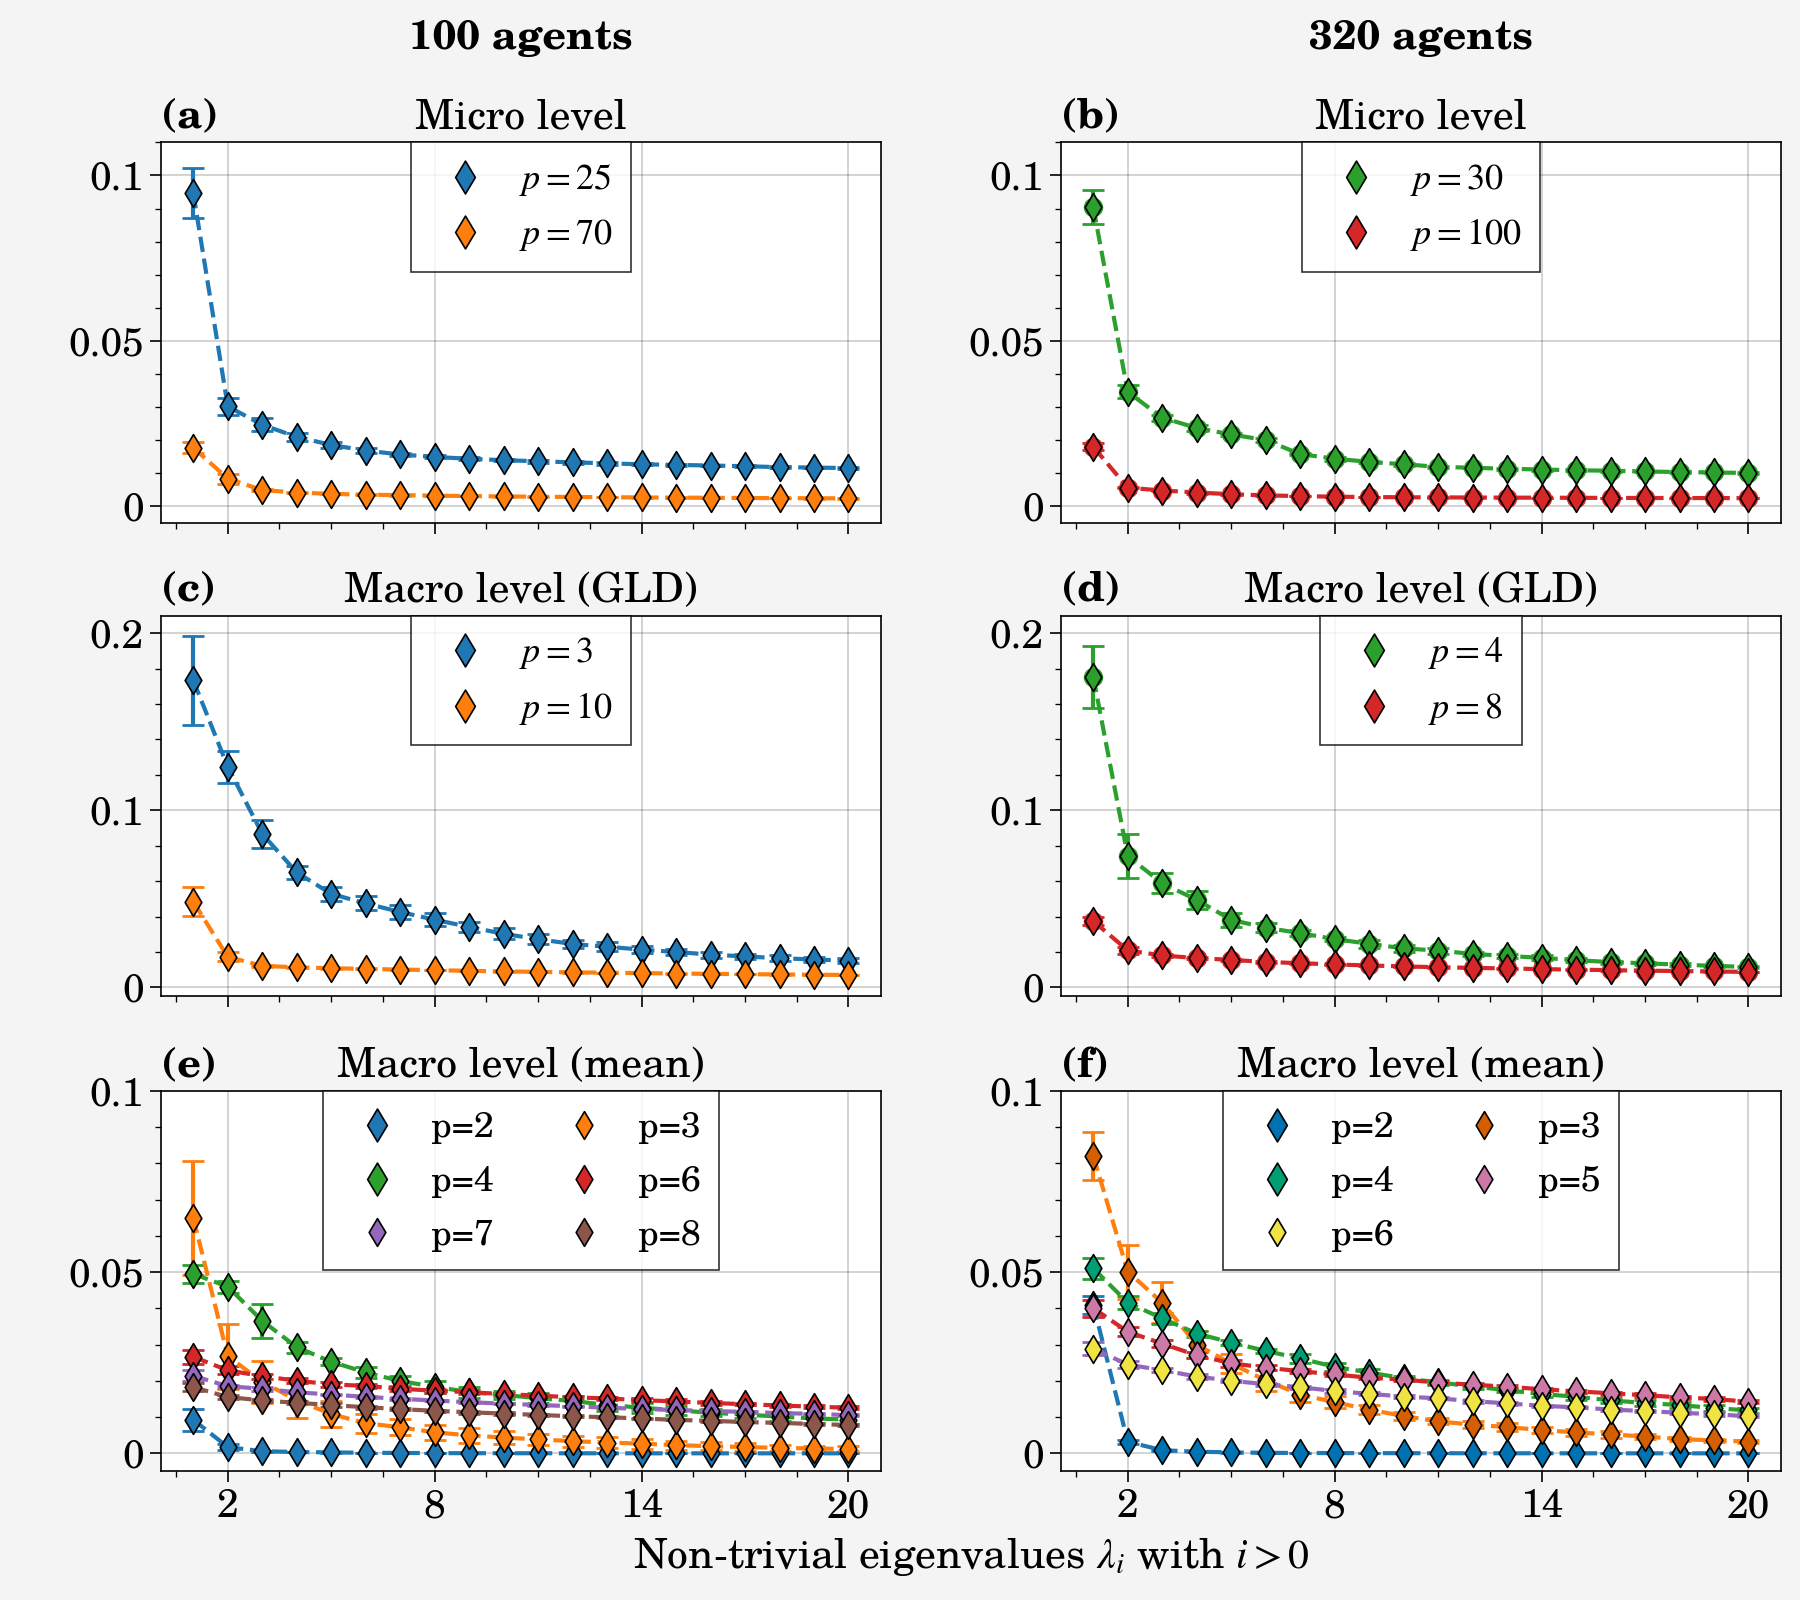

In [25]:
colors=mcp.gen_color(cmap="tab10",n=10)

ticks_x = np.linspace(2, 20, 4, dtype='int')

fig, axs = pplt.subplots(ncols=2, nrows=3, figsize=(9, 8), sharey=False, sharex=True)

# Micro screeplots
for i, p in enumerate([25, 70]):
    GSA_results_100 = np.load(PATH_TO_RESULTS + 
                              f"Numerical/GDMaps/GDMaps_parsim_pop100_runs_10_p_{p}.npz", 
                      allow_pickle=True)
    evals = GSA_results_100["x1"]
    x = np.arange(1, len(evals[0]), 1)
    axs[0].scatter(x, np.mean(evals, axis=0)[1:],
                   color=colors[i], label=r"$p={}$".format(p), 
                   edgecolor="k", marker="d", 
                   markersize=50, zorder=3)
    axs[0].errorbar(x, np.mean(evals, axis=0)[1:], 
                    np.std(evals, axis=0, ddof=1)[1:],
                    color=colors[i],
                    linestyle='--', capsize=4)
    axs[0].set_xticks(ticks_x,
                      ['{}'.format(num) for num in ticks_x])
    
    for i, ax in enumerate([axs[0], axs[1]]):
        ax.set_title("Micro level")
    
    
for i, p in enumerate([30, 100]):
    GSA_results_320 = np.load(PATH_TO_RESULTS + 
                              f"Numerical/GDMaps/GDMaps_parsim_pop320_runs_10_p_{p}.npz", 
                      allow_pickle=True)
    evals = GSA_results_320['x1']
    x = np.arange(1, len(evals[0]), 1)
    
    axs[1].scatter(x, np.mean(evals, axis=0)[1:],
                   color=colors[i+2], label=r"$p={}$".format(p), 
                   edgecolor='k', marker="d", 
                   markersize=50, zorder=3)
    axs[1].errorbar(x,
                    np.mean(evals, axis=0)[1:], 
                    np.std(evals, axis=0, ddof=1)[1:],
                    color=colors[i+2],
                    linestyle='--', marker='o', capsize=4)
    axs[1].set_xticks(ticks_x,
                      ['{}'.format(num) for num in ticks_x])
    
    
for i, ax in enumerate([axs[0], axs[1]]):
    ax.set_ylim(-0.005, 0.11)
    lgnd = ax.legend(fontsize=13, loc='uc', ncols=1)
    ax.set_xlabel(r'Non-trivial eigenvalues $\lambda_i$ with $i > 0$')
    lgnd.legendHandles[0]._sizes = [70]
    lgnd.legendHandles[1]._sizes = [70]   
    
    
# GLD screeplots
for i, p in enumerate([3,10]):
    GSA_results_100 = np.load(PATH_TO_RESULTS +
                              f"GLD/GDMaps/GLD_GDMaps_parsim_pop100_l34_runs_10_p_{p}.npz", 
                      allow_pickle=True)
    evals = GSA_results_100["x1"]
    x = np.arange(1, len(evals[0]), 1)
    axs[2].scatter(x, np.mean(evals, axis=0)[1:],
                   color=colors[i], label=r"$p={}$".format(p), 
                   edgecolor="k", marker="d", 
                   markersize=50, zorder=3)
    axs[2].errorbar(x, np.mean(evals, axis=0)[1:], 
                    np.std(evals, axis=0, ddof=1)[1:],
                    color=colors[i],
                    linestyle='--', capsize=4)
    axs[2].set_xticks(ticks_x,
                      ['{}'.format(num) for num in ticks_x])
       

for i, p in enumerate([4,8]):
    GSA_results_320 = np.load(PATH_TO_RESULTS + 
                              f"GLD/GDMaps/GLD_GDMaps_parsim_pop320_l34_runs_10_p_{p}.npz", 
                      allow_pickle=True)
    evals = GSA_results_320['x1']
    x = np.arange(1, len(evals[0]), 1)
    
    axs[3].scatter(x, np.mean(evals, axis=0)[1:],
                   color=colors[i+2], label=r"$p={}$".format(p), 
                   edgecolor='k', marker="d", 
                   markersize=50, zorder=3)
    axs[3].errorbar(x,
                    np.mean(evals, axis=0)[1:], 
                    np.std(evals, axis=0, ddof=1)[1:],
                    color=colors[i+2],
                    linestyle='--', marker='o', capsize=4)
    axs[3].set_xticks(ticks_x,
                      ['{}'.format(num) for num in ticks_x])
    
for i, ax in enumerate([axs[2], axs[3]]):
    ax.set_ylim(-0.005, 0.21)
    ax.set_title("Macro level (GLD)")
    lgnd = ax.legend(fontsize=13, loc='uc', ncols=1)
    ax.set_xlabel(r'Non-trivial eigenvalues $\lambda_i$ with $i > 0$')
    lgnd.legendHandles[0]._sizes = [70]
    lgnd.legendHandles[1]._sizes = [70]
    
    
# Micro screeplots
p_vals_100 = [2,3,4,6,7,8]
p_vals_320 = [2,3,4,5,6]


for i, f in enumerate(sorted([f for f in os.listdir(PATH_TO_RESULTS +"mean_macro/GDMaps/") 
                              if "pop100" in f])):
    GSA_results = np.load(PATH_TO_RESULTS +"mean_macro/GDMaps/" + f, allow_pickle=True)
    evals = GSA_results['x1']
    
    axs[4].scatter(np.arange(1, len(evals[0]), 1), np.mean(evals, axis=0)[1:], 
                label=f"p={p_vals_100[i]}", edgecolor="k", marker="d", 
                markersize=50, zorder=3, color=colors[i])
    
    axs[4].errorbar(np.arange(1, len(evals[0]), 1),
                 np.mean(evals, axis=0)[1:], 
                 np.std(evals, axis=0, ddof=1)[1:],
                 color=colors[i],
                 linestyle='--', capsize=4)
    axs[4].set_xticks(ticks_x,
                      ['{}'.format(num) for num in ticks_x])

for i, f in enumerate(sorted([f for f in os.listdir(PATH_TO_RESULTS +"mean_macro/GDMaps/") 
                              if "pop320" in f])):
    GSA_results = np.load(PATH_TO_RESULTS +"mean_macro/GDMaps/" + f, allow_pickle=True)
    evals = GSA_results['x1']
    
    axs[5].scatter(np.arange(1, len(evals[0]), 1), np.mean(evals, axis=0)[1:], 
                label=f"p={p_vals_320[i]}", edgecolor="k", marker="d", 
                markersize=50, zorder=3)
    
    axs[5].errorbar(np.arange(1, len(evals[0]), 1),
             np.mean(evals, axis=0)[1:], 
             np.std(evals, axis=0, ddof=1)[1:],
             color=colors[i],
             linestyle='--', capsize=4)
    axs[5].set_xticks(ticks_x,
              ['{}'.format(num) for num in ticks_x])
    
for i, ax in enumerate([axs[4], axs[5]]):
    ax.set_title("Macro level (mean)")
    ax.set_ylim(-0.005, 0.1)
    lgnd = ax.legend(fontsize=13, loc='uc', ncols=2)
    ax.set_xlabel(r'Non-trivial eigenvalues $\lambda_i$ with $i > 0$')
    lgnd.legendHandles[0]._sizes = [70]
    lgnd.legendHandles[1]._sizes = [70]
    

    
axs[0].set_ylabel(" ")
axs[1].set_ylabel(" ")

axs.format(toplabels=["100 agents", "320 agents"])
axs.format(abc='(a)')

axs.format(rc_kw={'label.size': 15,
                  'toplabel.pad': 15,
                  'tick.labelsize': 14,
                  'title.size': 15})
        
plt.tight_layout()

plt.savefig('plots/Sugarscape/Sugarscape_all_screeplots.pdf', bbox_inches='tight')
plt.show()

## Histogram (Micro)

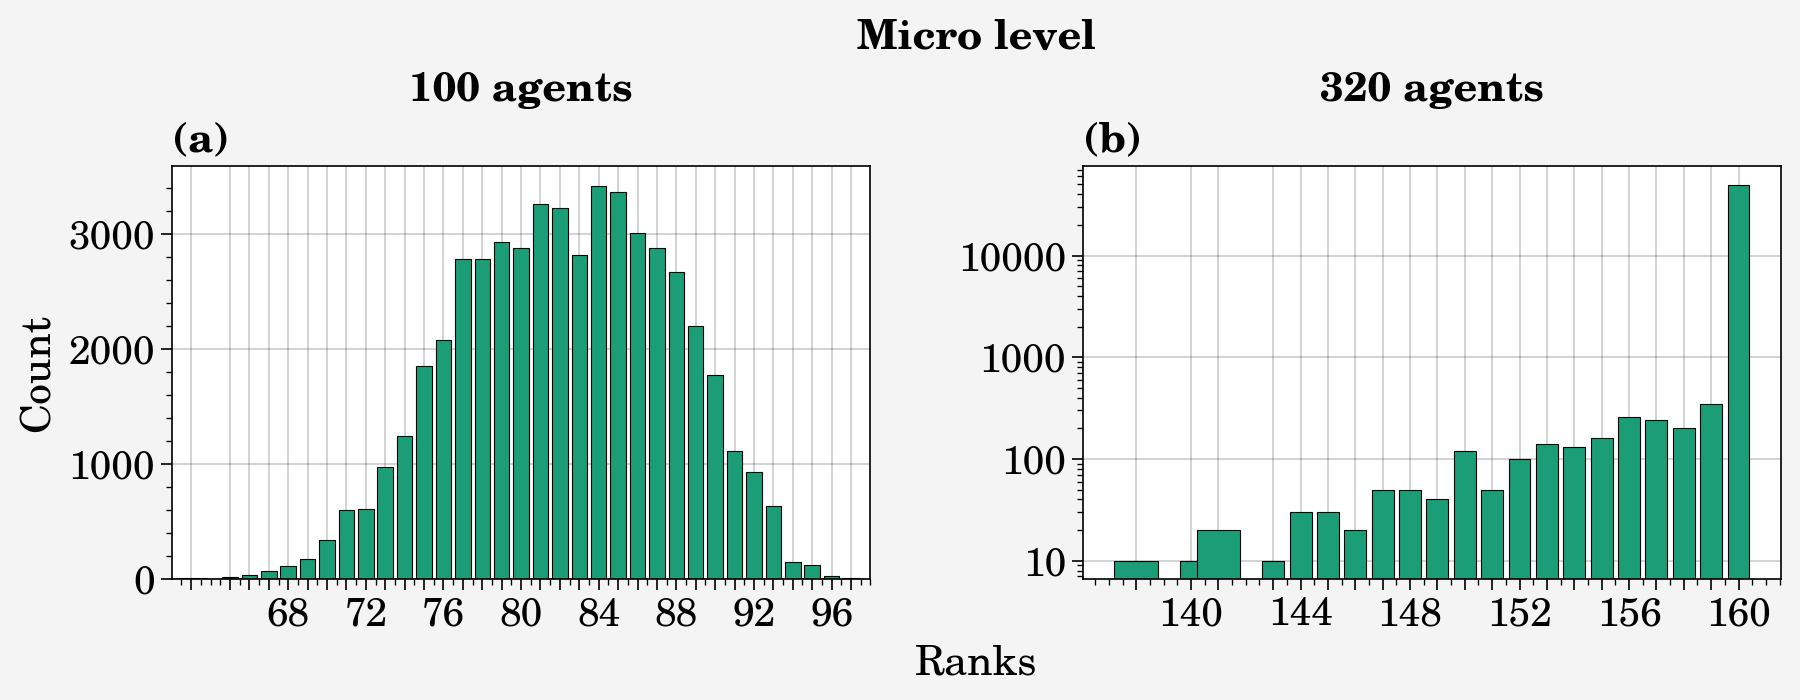

In [26]:
fig, axs = pplt.subplots(ncols=2, nrows=1, figsize=(9, 3.5), sharey=False, sharex=True)

# histograms
axs[0].bar(unique_100_micro, counts_100_micro, facecolor = '#1b9e77', edgecolor='k', linewidth=0.4)
xticks_label_100 = ['{}'.format(num) if num % 4 == 0 else ' ' for num in unique_100_micro]
axs[0].set_xticks(unique_100_micro, xticks_label_100)
axs[0].set_xlim(62, 98)

axs[1].bar(unique_320_micro, counts_320_micro, facecolor = '#1b9e77', edgecolor='k', linewidth=0.4)
xticks_label_320 = ['{}'.format(num) if num % 4 == 0 else ' ' for num in unique_320_micro]
axs[1].set_xticks(unique_320_micro, xticks_label_320)

for ax in [axs[0],axs[1]]:
    ax.set_xlabel(r"Ranks")
#     ax.set_ylabel(r"Count") 
    
axs[0].set_ylabel("Count")
axs[1].set_ylabel(" ")
axs[1].set_yscale("log")
    
axs.format(toplabels=["100 agents", "320 agents"],
           suptitle = "Micro level")
axs.format(abc='(a)')
axs.format(rc_kw={'label.size': 15,
                  'tick.labelsize': 14,
                  'title.size': 15})
    
plt.tight_layout()
plt.savefig('plots/Sugarscape/Sugarscape_micro_hist.pdf', bbox_inches='tight')
plt.show()